In [1]:
# Python SQL toolkit and Object Relational Mapper and Matplotlib Import
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, Column, Integer, String, func, distinct, desc
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy.orm.query import Query
from pprint import pprint

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

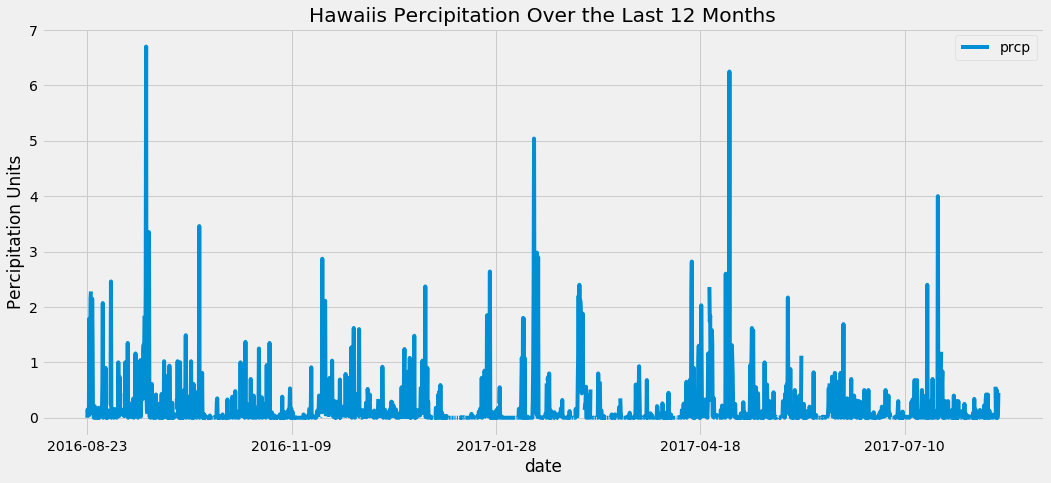

In [9]:
# Design a query to retrieve the last 12 months of precipitation data
data = pd.read_sql("SELECT date, prcp FROM measurement WHERE date BETWEEN '2016-08-23' AND '2017-08-23' ORDER BY date ASC", conn)
data.head()

#Set Index
data_index = data.set_index('date')
data_index.head()

#Plot the results
fig1, ax1 = plt.subplots()
data_index.plot(kind= 'line',
               ax = ax1,
               figsize = (16,7),
               grid = True,
               legend = True,
               title = 'Hawaiis Percipitation Over the Last 12 Months')
ax1.set_ylabel('Percipitation Units')
fig1.savefig('Hawaiis Percipitation Over the Last 12 Months')


In [10]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data_index.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [11]:
# Design a query to show how many stations are available in this dataset
station_count = pd.read_sql("SELECT COUNT(station) AS station_count FROM station", conn)
station_count

,station_count
0,9


In [12]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station = pd.read_sql("SELECT station, COUNT(station) AS station_count FROM measurement GROUP BY station ORDER BY station_count DESC", conn)
active_station

,station,station_count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [13]:
#Most active station
active_station = pd.read_sql("SELECT station, COUNT(station) AS station_activity FROM measurement GROUP BY station ORDER BY station_activity DESC", conn)
active_station

# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp_stats = pd.read_sql("SELECT station, MAX(tobs), MIN(tobs), AVG(tobs) FROM measurement WHERE station= 'USC00519281'", conn)
temp_stats

,station,MAX(tobs),MIN(tobs),AVG(tobs)
0,USC00519281,85.0,54.0,71.663781


In [14]:
# Choose the station with the highest number of temperature observations.
most_active_station = pd.read_sql("SELECT date, tobs FROM measurement WHERE station= 'USC00519281'AND date BETWEEN '2016-08-23' AND '2017-08-23' ORDER BY date ASC", conn)
most_active_station

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
...,...,...
347,2017-08-14,77.0
348,2017-08-15,77.0
349,2017-08-16,76.0
350,2017-08-17,76.0


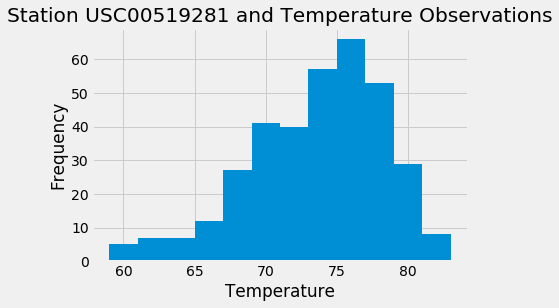

In [15]:
# fig2, ax2 = plt.subplots(figsize = (10,8))
fig2 = most_active_station.hist(bins=12, label = 'tobs')
plt.title('Station USC00519281 and Temperature Observations')
plt.xlabel('Temperature')
plt.ylabel('Frequency')

plt.savefig('Station USC00519281 and Temperature Observations')


In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
beg_2017 = '2017-01-01'
end_2017 = '2017-12-31'
trip_2017 = calc_temps(beg_2017, end_2017)
# print(trip_2017)
print(f'''Temperature ranges between {beg_2017} and {end_2017} are:{trip_2017}''')

Temperature ranges between 2017-01-01 and 2017-12-31 are:[(58.0, 74.14387974230493, 87.0)]


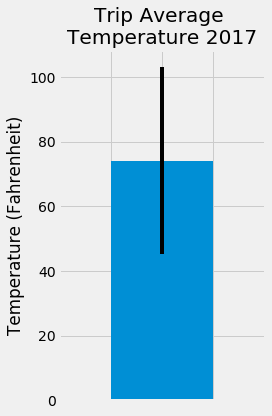

In [48]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig3, ax3 = plt.subplots(figsize=(4,6))

min_2017 = trip_2017 [0][0]
avg_2017 = trip_2017 [0][1]
max_2017 = trip_2017 [0][2]

y_error = max_2017 - min_2017

ax3.bar(x=0, height=avg_2017,width=0.1, yerr = y_error);
ax3.set_xlim(xmin=-0.1, xmax=0.1);
ax3.set_xticklabels([]);
ax3.set_ylabel('Temperature (Fahrenheit)');
ax3.set_title('Trip Average \nTemperature 2017');
fig3.tight_layout();
fig3.savefig('Trip Average Temperature 2017.png');

In [65]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

results = \
session.query(
    Station.station,
    Station.latitude,
    Station.longitude,
    Station.elevation,
    func.round(func.sum(Measurement.prcp),2)
)\
.filter(Station.station == Measurement.station)\
.filter(Measurement.date.between('2016-08-23', '2017-08-23'))\
.group_by(Station.station)\
.order_by(desc(func.round(func.sum(Measurement.prcp),2))).all()

results

[('USC00516128', 21.3331, -157.8025, 152.4, 147.81),
 ('USC00519281', 21.45167, -157.84888999999998, 32.9, 70.03),
 ('USC00513117', 21.4234, -157.8015, 14.6, 48.51),
 ('USC00519523', 21.33556, -157.71139, 19.5, 38.01),
 ('USC00514830', 21.5213, -157.8374, 7.0, 33.24),
 ('USC00519397', 21.2716, -157.8168, 3.0, 16.09),
 ('USC00517948', 21.3934, -157.9751, 11.9, 4.59)]